DarkFace dataset (low-light obstacle detection scenario), let’s implement your classical vision-based obstacle detection pipeline (CLAHE + Gamma + Contours) with evaluation metrics (Precision, Recall, F1-score, Detection Rate) in a Kaggle-friendly format.

# IMPORTING LIBRARIES

In [79]:
import cv2
import numpy as np
import os
from sklearn.metrics import precision_score,recall_score,f1_score

In [80]:
IMG_DIR = '/kaggle/input/dark-face-dataset/image'
LABEL_DIR = '/kaggle/input/dark-face-dataset/labels'

# NOTE
*MIN_CONTOUR_AREA = 400 filters out small, noisy detections in the image.*\
*GAMMA = 1.5 brightens darker regions to enhance visibility and detection accuracy.*\
*FOCAL_LENGTH_PX = 700 is an approximate camera focal length in pixels, used to estimate object distance.*\
*REAL_OBSTACLE_HEIGHT = 1.6 m represents a typical human torso height for real-world distance calculation*.

In [81]:
import time
import matplotlib.pyplot as plt

#Standard metrics
MIN_CONTOUR_AREA = 400
GAMMA = 1.5
FOCAL_LENGTH_PX = 700  # approximate focal length in pixels
REAL_OBSTACLE_HEIGHT = 1.6  # meters (approximate human torso height)

In [82]:
'''def image_enhancement(img):
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    #FOR CONTRAST
    clahe = cv2.createCLAHE(clipLimit = 2.0,tileGridSize = (8,8))
    clahe_img = clahe.apply(gray)
    #GAMMA CORRECTION
    gamma = 1.5
    gamma_corr = np.power(clahe_img/255.0,gamma)
    gamma_corr = np.uint8(gamma_corr*255)
    #denoise 
    denoised = cv2.fastNlMeansDenoising(gamma_corr,None,10,7,21)
    return denoised'''

'def image_enhancement(img):\n    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)\n    #FOR CONTRAST\n    clahe = cv2.createCLAHE(clipLimit = 2.0,tileGridSize = (8,8))\n    clahe_img = clahe.apply(gray)\n    #GAMMA CORRECTION\n    gamma = 1.5\n    gamma_corr = np.power(clahe_img/255.0,gamma)\n    gamma_corr = np.uint8(gamma_corr*255)\n    #denoise \n    denoised = cv2.fastNlMeansDenoising(gamma_corr,None,10,7,21)\n    return denoised'

# **BETTER ENHANCEMENT**

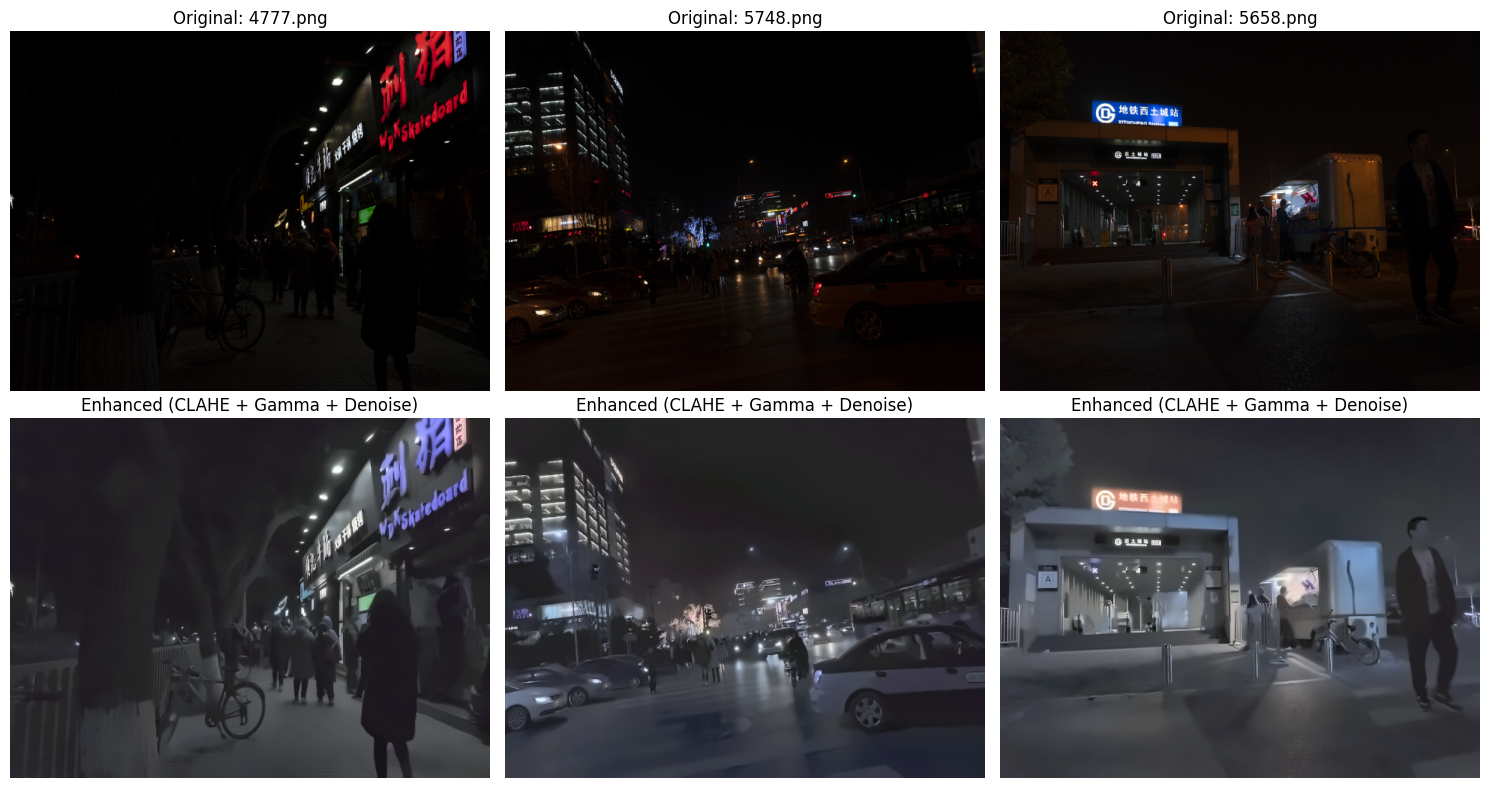

In [83]:
def image_enhancement(img):
    #Convert to LAB for better lightness adjustment
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)

    #CLAHE on L-channel for contrast enhancement (bright areas are unaffected)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    l_clahe = clahe.apply(l)

    #Merge back both and convert to BGR
    lab_clahe = cv2.merge((l_clahe, a, b))
    enhanced = cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2BGR)

    #Gamma correction
    gamma = 0.6  #  brightens instead of darkens
    look_up = np.array([((i / 255.0) ** gamma) * 255 for i in np.arange(256)]).astype("uint8")
    gamma_corrected = cv2.LUT(enhanced, look_up)

    #Denoising
    denoised = cv2.fastNlMeansDenoisingColored(gamma_corrected, None, 10, 10, 7, 21)

    return denoised

#Visualization of the image Enhancement 
all_imgs = [f for f in os.listdir(IMG_DIR) if f.endswith(('.png', '.jpg'))]
sample_imgs = random.sample(all_imgs, 3)  

plt.figure(figsize=(15, 8))
for i, fname in enumerate(sample_imgs, 1):
    path = os.path.join(IMG_DIR, fname)
    img = cv2.imread(path)
    if img is None:
        continue

    img = cv2.resize(img, (640, 480))
    enhanced = image_enhancement(img)

    plt.subplot(2, 3, i)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(f"Original: {fname}")
    plt.axis('off')

    plt.subplot(2, 3, i + 3)
    plt.imshow(enhanced, cmap='gray')
    plt.title("Enhanced (CLAHE + Gamma + Denoise)")
    plt.axis('off')

plt.tight_layout()
plt.show()

Whats in the above code \
CLAHE enhances contrast in the L-channel of the LAB color space, improving detail in both bright and dark regions.

Gamma correction brightens the overall tone.

Denoising smooths out color noise while preserving edges.

The loop applies this to three random images, displaying the original vs. enhanced versions side by side for comparison.


# obstacle detection

Canny edge detector is used(highlights strong edges,applies thresholds 50,150,converts the imaeg into a binary edge map)

contours : Extracts external contours

returns bounding Boxes 

In [84]:
def detect_obstacles(img_enhanced):
    edges = cv2.Canny(img_enhanced, 50, 150)
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    det_bboxes = []
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area > MIN_CONTOUR_AREA:
            x, y, w, h = cv2.boundingRect(cnt)
            det_bboxes.append([x, y, x + w, y + h])
    return det_bboxes,edges

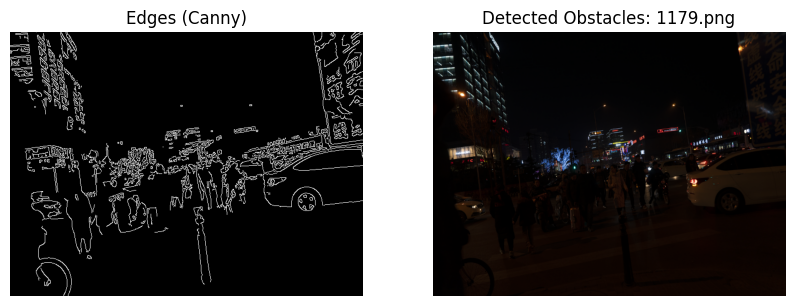

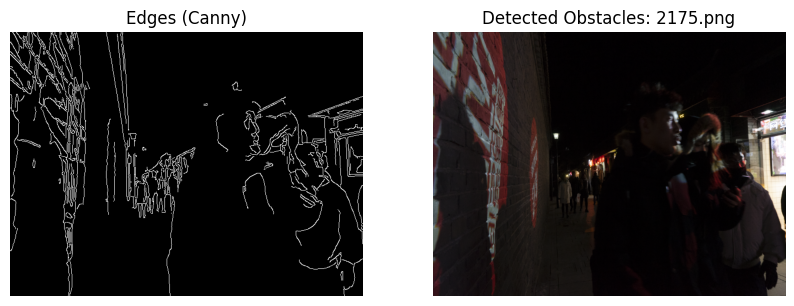

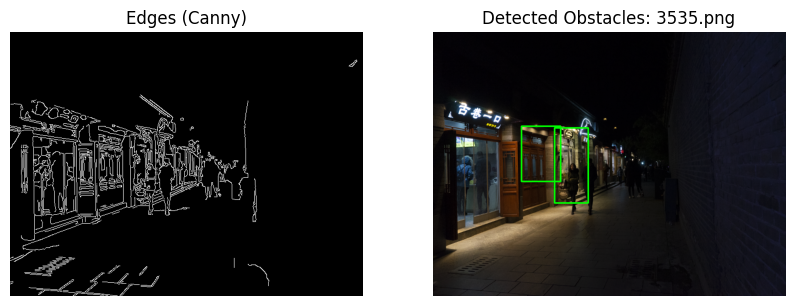

In [85]:
def visualize_detections(img_enhanced, det_bboxes, edges, title=None):
    # To Handle grayscale(if given) or color input 
    if len(img_enhanced.shape) == 2 or (len(img_enhanced.shape) == 3 and img_enhanced.shape[2] == 1):
        img_vis = cv2.cvtColor(img_enhanced, cv2.COLOR_GRAY2BGR)
    else:
        img_vis = img_enhanced.copy()

    # Drawing bounding boxes
    for (x1, y1, x2, y2) in det_bboxes:
        cv2.rectangle(img_vis, (x1, y1), (x2, y2), (0, 255, 0), 2)

    # Shows edges + detections
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Edges (Canny)")
    plt.imshow(edges, cmap='gray')
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.title(title if title else "Detected Obstacles")
    plt.imshow(cv2.cvtColor(img_vis, cv2.COLOR_BGR2RGB))
    plt.axis("off")

    plt.show()

all_imgs = [f for f in os.listdir(IMG_DIR) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
sample_imgs = random.sample(all_imgs, 3)

for img_name in sample_imgs:
    img_path = os.path.join(IMG_DIR, img_name)
    img = cv2.imread(img_path)  # removes IMREAD_GRAYSCALE
    img = cv2.resize(img, (640, 480))
    enhanced = image_enhancement(img)
    det_bboxes, edges = detect_obstacles(enhanced)
    visualize_detections(img, det_bboxes, edges, title=f"Detected Obstacles: {img_name}")

## *Using existing labels*

In [86]:
LABEL_DIR = "/kaggle/input/dark-face-dataset/label"


# Load labels for a single image
def load_labels(label_path):
    label_bboxes = []
    if not os.path.exists(label_path):
        return label_bboxes  # no labels available for this image

    with open(label_path, "r") as f:
        lines = f.readlines()
        if len(lines) == 0:
            return label_bboxes
        num_labels = int(lines[0].strip())
        for line in lines[1:num_labels + 1]:
            x1, y1, x2, y2 = map(int, line.strip().split())
            label_bboxes.append([x1, y1, x2, y2])
    return label_bboxes

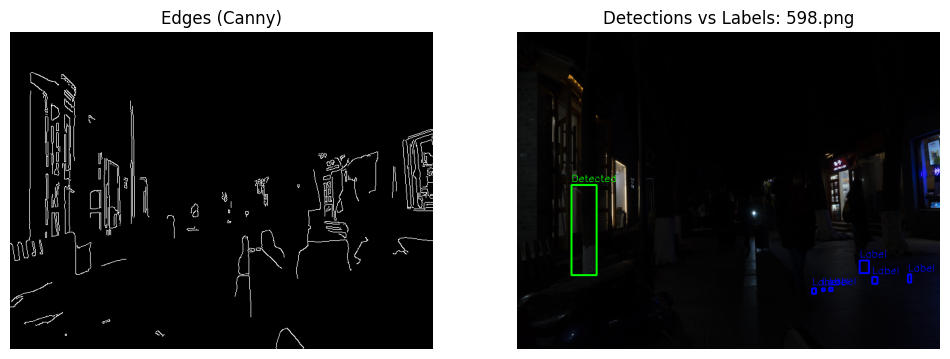

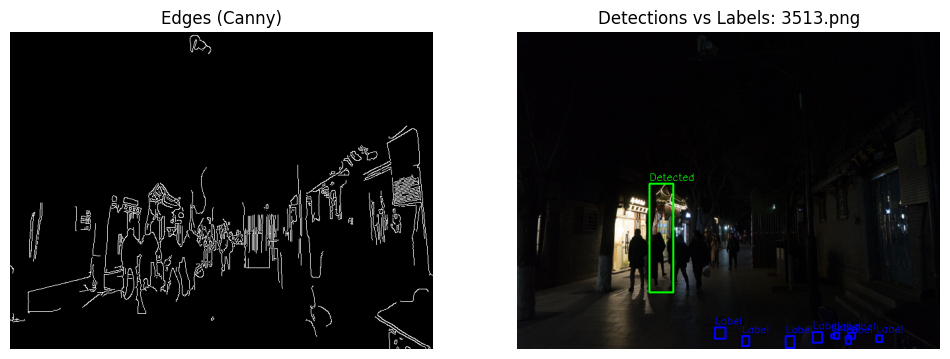

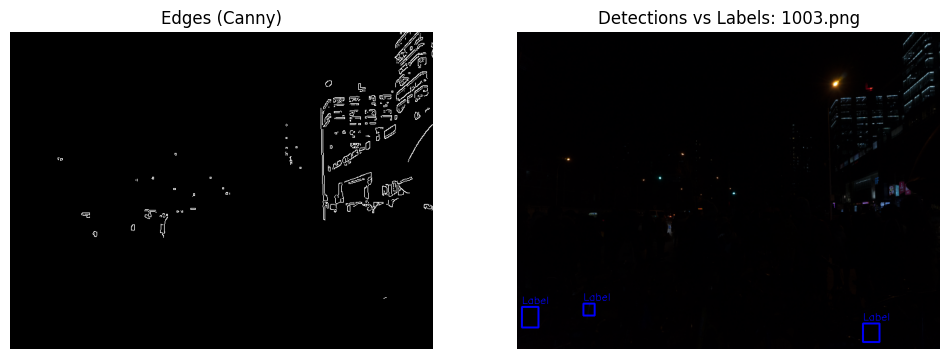

In [87]:
#Visualization function
def visualize_with_labels(img, det_bboxes, label_bboxes, edges, title=None):
    if len(img.shape) == 2 or (len(img.shape) == 3 and img.shape[2] == 1):
        img_vis = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    else:
        img_vis = img.copy()

    # Draw detected boxes (green)
    for (x1, y1, x2, y2) in det_bboxes:
        cv2.rectangle(img_vis, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(img_vis, "Detected", (x1, y1 - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

    # Draw label boxes (red)
    for (x1, y1, x2, y2) in label_bboxes:
        cv2.rectangle(img_vis, (x1, y1), (x2, y2), (255, 0, 0), 2)
        cv2.putText(img_vis, "Label", (x1, y1 - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title("Edges (Canny)")
    plt.imshow(edges, cmap='gray')
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.title(title if title else "Detections vs Labels")
    plt.imshow(cv2.cvtColor(img_vis, cv2.COLOR_BGR2RGB))
    plt.axis("off")

    plt.show()


# Main loop 
all_imgs = [f for f in os.listdir(IMG_DIR) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
sample_imgs = random.sample(all_imgs, 3)

for img_name in sample_imgs:
    img_path = os.path.join(IMG_DIR, img_name)
    label_path = os.path.join(LABEL_DIR, os.path.splitext(img_name)[0] + ".txt")

    img = cv2.imread(img_path)
    img = cv2.resize(img, (640, 480))

    enhanced = image_enhancement(img)
    det_bboxes, edges = detect_obstacles(enhanced)
    label_bboxes = load_labels(label_path)

    visualize_with_labels(img, det_bboxes, label_bboxes, edges, title=f"Detections vs Labels: {img_name}")

In [88]:
#THE below function tracks motion between two consecutive grayscale frames using optical flow.
def track_motion(prev_gray, curr_gray):
    # Detect feature points
    prev_pts = cv2.goodFeaturesToTrack(prev_gray, mask=None, maxCorners=100, qualityLevel=0.3, minDistance=7)
    if prev_pts is None:
        return curr_gray, None

    # Calculate optical flow (Lucas-Kanade)
    curr_pts, status, _ = cv2.calcOpticalFlowPyrLK(prev_gray, curr_gray, prev_pts, None)

    # Draw motion vectors
    motion_mask = np.zeros_like(curr_gray)
    if curr_pts is not None:
        for (new, old) in zip(curr_pts[status == 1], prev_pts[status == 1]):
            a, b = new.ravel()
            c, d = old.ravel()
            cv2.line(motion_mask, (int(a), int(b)), (int(c), int(d)), 255, 1)

    # Combine motion mask with current frame
    motion_combined = cv2.addWeighted(curr_gray, 0.8, motion_mask, 0.2, 0)
    return motion_combined, curr_pts


track_motion() detects feature points in one frame and tracks their movement in the next using the Lucas–Kanade optical flow method.
It draws motion vectors showing how points have shifted between frames.
The function then overlays these motion lines on the current image and returns both the visualized frame and the new point positions.

In [89]:
#Applies pinhole camera model:
def estimate_distance(bbox):
    x1, y1, x2, y2 = bbox
    h = abs(y2 - y1)
    if h == 0:
        return None
    distance = (REAL_OBSTACLE_HEIGHT * FOCAL_LENGTH_PX) / h
    return distance

In [90]:
from gtts import gTTS
from IPython.display import Audio, display

In [91]:
def feedback(dist):
    """Generate and play voice feedback based on estimated distance."""
    if dist < 2:
        message = f"Warning! Obstacle only {dist:.1f} meters ahead."
    elif dist < 5:
        message = f"Obstacle detected {dist:.1f} meters away."
    else:
        message = f"Clear path. Object {dist:.1f} meters ahead."

    tts = gTTS(text=message, lang='en')
    filename = "alert.mp3"
    tts.save(filename)
    display(Audio(filename))

In [92]:
import os
print(IMG_DIR)
print(len(os.listdir(IMG_DIR)))
print([f for f in os.listdir(IMG_DIR)[:10]])


/kaggle/input/dark-face-dataset/image
6000
['4353.png', '5511.png', '2664.png', '2539.png', '5703.png', '1231.png', '1017.png', '4803.png', '2437.png', '3217.png']


In [93]:
image_files = sorted([
    f for f in os.listdir(IMG_DIR)
    if f.lower().endswith((".jpg", ".png"))
])[:50]
print(f"Found {len(image_files)} images to process.")
print("Example files:", image_files[:5])

Found 50 images to process.
Example files: ['1.png', '10.png', '100.png', '1000.png', '1001.png']


In [94]:
!pip install gTTs

This includes:

image enhancement

obstacle detection (via contours)

distance estimation (approximate using known object height + camera parameters)

optional FPS tracking

optional voice feedback (function hook, not actual sound code here — you can add TTS later)

distance = (REAL_OBJECT_HEIGHT * FOCAL_LENGTH) / h

an approximation based on the pinhole camera model.
It mathematically estimates the distance from the camera to the object using geometry, assuming:

The camera behaves like an ideal pinhole camera,

The object has a known real-world height (REAL_OBJECT_HEIGHT), and

The focal length (FOCAL_LENGTH) is known (in pixels).

So, it’s a physically meaningful formula, not random — but the accuracy depends heavily on how realistic those assumptions are.

In [96]:
prev_gray = None
fps_list = []

for fname in tqdm(image_files):
    img_path = os.path.join(IMG_DIR, fname)
    img = cv2.imread(img_path)
    if img is None:
        continue

    start_time = time.time()

    # Enhance and detect
    enhanced = image_enhancement(img)
    det_bboxes, edges = detect_obstacles(enhanced)

    # Optical flow (optional)
    curr_gray = cv2.cvtColor(enhanced, cv2.COLOR_BGR2GRAY)
    if prev_gray is not None:
        flow_vis, _ = track_motion(prev_gray, curr_gray)
    else:
        flow_vis = curr_gray
    prev_gray = curr_gray.copy()

    # Distance estimation + feedback
    if det_bboxes:
        distances = [estimate_distance(bbox) for bbox in det_bboxes]
        distances = [d for d in distances if d is not None]

        if distances:
            nearest = min(distances)
            feedback(nearest)
            cv2.putText(img, f"Nearest: {nearest:.2f}m", (10, 55),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

    # FPS calculation
    end_time = time.time()
    fps = 1 / (end_time - start_time)
    fps_list.append(fps)
    cv2.putText(img, f"FPS: {fps:.2f}", (10, 25),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 0), 2)

    # Optional visualization (for debugging)
    # visualize_detections(img, det_bboxes, edges, title=fname)

print(f"\n✅ Average FPS: {np.mean(fps_list):.2f}")

  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:03,  1.30s/it]

  4%|▍         | 2/50 [00:02<01:01,  1.27s/it]

  6%|▌         | 3/50 [00:03<01:00,  1.28s/it]

  8%|▊         | 4/50 [00:05<00:58,  1.27s/it]

 10%|█         | 5/50 [00:06<00:56,  1.25s/it]

 16%|█▌        | 8/50 [00:09<00:48,  1.16s/it]

 18%|█▊        | 9/50 [00:11<00:49,  1.20s/it]

 20%|██        | 10/50 [00:12<00:49,  1.23s/it]

 22%|██▏       | 11/50 [00:13<00:48,  1.24s/it]

 24%|██▍       | 12/50 [00:14<00:47,  1.25s/it]

 26%|██▌       | 13/50 [00:16<00:45,  1.23s/it]

 28%|██▊       | 14/50 [00:17<00:44,  1.24s/it]

 30%|███       | 15/50 [00:18<00:43,  1.24s/it]

 32%|███▏      | 16/50 [00:19<00:42,  1.24s/it]

 34%|███▍      | 17/50 [00:21<00:41,  1.27s/it]

 36%|███▌      | 18/50 [00:22<00:40,  1.26s/it]

 38%|███▊      | 19/50 [00:23<00:38,  1.25s/it]

 40%|████      | 20/50 [00:24<00:37,  1.24s/it]

 42%|████▏     | 21/50 [00:26<00:35,  1.23s/it]

 44%|████▍     | 22/50 [00:27<00:34,  1.22s/it]

 46%|████▌     | 23/50 [00:28<00:33,  1.24s/it]

 48%|████▊     | 24/50 [00:29<00:31,  1.23s/it]

 50%|█████     | 25/50 [00:30<00:31,  1.24s/it]

 52%|█████▏    | 26/50 [00:32<00:29,  1.23s/it]

 54%|█████▍    | 27/50 [00:33<00:28,  1.24s/it]

 56%|█████▌    | 28/50 [00:34<00:26,  1.22s/it]

 58%|█████▊    | 29/50 [00:35<00:25,  1.19s/it]

 60%|██████    | 30/50 [00:36<00:24,  1.20s/it]

 62%|██████▏   | 31/50 [00:38<00:22,  1.21s/it]

 64%|██████▍   | 32/50 [00:39<00:21,  1.18s/it]

 66%|██████▌   | 33/50 [00:40<00:20,  1.20s/it]

 68%|██████▊   | 34/50 [00:41<00:19,  1.22s/it]

 70%|███████   | 35/50 [00:43<00:18,  1.23s/it]

 72%|███████▏  | 36/50 [00:44<00:17,  1.24s/it]

 74%|███████▍  | 37/50 [00:45<00:16,  1.24s/it]

 76%|███████▌  | 38/50 [00:46<00:15,  1.25s/it]

 78%|███████▊  | 39/50 [00:48<00:13,  1.26s/it]

 80%|████████  | 40/50 [00:49<00:12,  1.24s/it]

 82%|████████▏ | 41/50 [00:50<00:11,  1.26s/it]

 84%|████████▍ | 42/50 [00:51<00:09,  1.21s/it]

 86%|████████▌ | 43/50 [00:52<00:08,  1.23s/it]

 88%|████████▊ | 44/50 [00:54<00:07,  1.24s/it]

 90%|█████████ | 45/50 [00:55<00:06,  1.24s/it]

 92%|█████████▏| 46/50 [00:56<00:05,  1.25s/it]

 94%|█████████▍| 47/50 [00:58<00:03,  1.26s/it]

 96%|█████████▌| 48/50 [00:59<00:02,  1.22s/it]

 98%|█████████▊| 49/50 [01:00<00:01,  1.23s/it]

100%|██████████| 50/50 [01:01<00:00,  1.23s/it]


✅ Average FPS: 0.83


# **TEST CASES**


Voice Feedback: Clear path. Nearest object 15.8 meters ahead.


FPS: 0.93


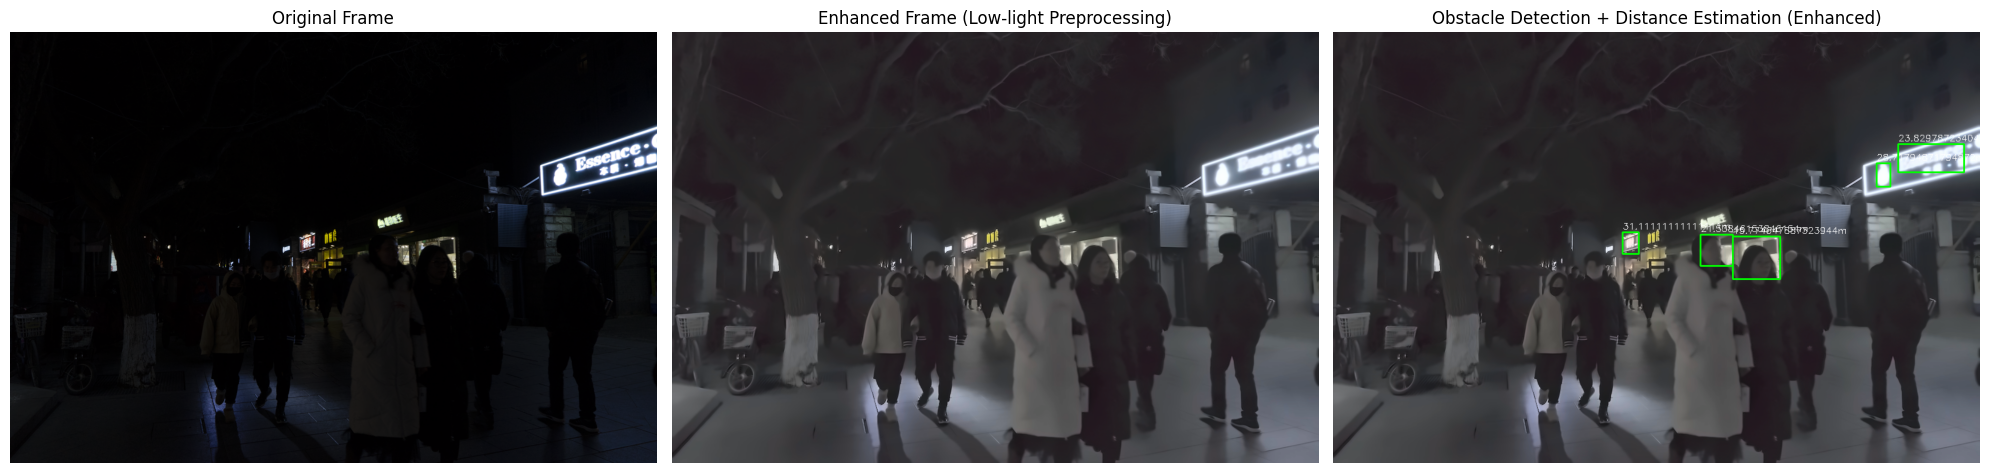

In [104]:
frame3_path = '/kaggle/input/dark-face-dataset/image/1008.png'
frame3 = cv2.imread(frame3_path)

if frame3 is None:
    raise FileNotFoundError(f"Could not load image: {frame3_path}")

start_time = time.time()

# === Enhancement and detection on ENHANCED image ===
enh1 = image_enhancement(frame3)
dets, edges = detect_obstacles(enh1)

# === Distance estimation (on enhanced detections) ===
distances = [estimate_distance(b) for b in dets if estimate_distance(b) is not None]
nearest = min(distances) if distances else None

# === Draw detections on ENHANCED image ===
vis_img = enh1.copy()
for (x1, y1, x2, y2) in dets:
    cv2.rectangle(vis_img, (x1, y1), (x2, y2), (0, 255, 0), 2)
    d = estimate_distance([x1, y1, x2, y2])
    if d:
        cv2.putText(vis_img, f"{d}m", (x1, y1 - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)

# === gTTS voice feedback ===
OUTPUT_AUDIO = "feedback.mp3"

if nearest:
    if nearest < 2:
        msg = f"Warning! Obstacle only {nearest:.1f} meters ahead."
    elif nearest < 5:
        msg = f"Obstacle detected {nearest:.1f} meters away."
    else:
        msg = f"Clear path. Nearest object {nearest:.1f} meters ahead."
else:
    msg = "No obstacles detected. Path is clear."

print("\nVoice Feedback:", msg)
tts = gTTS(text=msg, lang='en')
tts.save(OUTPUT_AUDIO)
display(Audio(OUTPUT_AUDIO, autoplay=True))

# === FPS Logging ===
fps = 1.0 / (time.time() - start_time)
print(f"FPS: {fps:.2f}")

# === Visualization ===
fig, axs = plt.subplots(1, 3, figsize=(20, 6))

axs[0].imshow(cv2.cvtColor(frame3, cv2.COLOR_BGR2RGB))
axs[0].set_title("Original Frame")
axs[0].axis("off")

axs[1].imshow(cv2.cvtColor(enh1, cv2.COLOR_BGR2RGB))
axs[1].set_title("Enhanced Frame (Low-light Preprocessing)")
axs[1].axis("off")

axs[2].imshow(cv2.cvtColor(vis_img, cv2.COLOR_BGR2RGB))
axs[2].set_title("Obstacle Detection + Distance Estimation (Enhanced)")
axs[2].axis("off")

plt.tight_layout()
plt.show()
